In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from transformers import ViTForImageClassification
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pickle


/fab3/btech/2021/manish.kumar21b/anaconda3/envs/manish/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dir = "/fab3/btech/2021/manish.kumar21b/manish/PlantPedia/endsem/swedish_dataset/train"
test_dir = "/fab3/btech/2021/manish.kumar21b/manish/PlantPedia/endsem/swedish_dataset/test"


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)


In [6]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for param in model.parameters():
    param.requires_grad = False  


In [8]:
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 512), 
    nn.ReLU(), 
    nn.Dropout(0.5), 
    nn.Linear(512, len(train_dataset.classes))
)

In [9]:
for param in model.classifier.parameters():
    param.requires_grad = True  


In [10]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)  


In [12]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [13]:
num_epochs = 20
best_val_loss = float('inf')
patience = 3  
patience_counter = 0

In [14]:


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs.logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    
    scheduler.step()

    
    model.eval()
    val_loss = 0.0
    total_correct = 0
    total_images = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total_correct += (predicted == labels).sum().item()
            total_images += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_loss /= len(test_loader)
    accuracy = total_correct / total_images
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

   
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/20, Training Loss: 2.1874
Validation Loss: 0.9478, Accuracy: 0.8452
Epoch 2/20, Training Loss: 0.8483
Validation Loss: 0.4636, Accuracy: 0.8677
Epoch 3/20, Training Loss: 0.5456
Validation Loss: 0.3156, Accuracy: 0.9403
Epoch 4/20, Training Loss: 0.4128
Validation Loss: 0.2514, Accuracy: 0.9484
Epoch 5/20, Training Loss: 0.3164
Validation Loss: 0.2217, Accuracy: 0.9403
Epoch 6/20, Training Loss: 0.2795
Validation Loss: 0.1996, Accuracy: 0.9597
Epoch 7/20, Training Loss: 0.2570
Validation Loss: 0.1911, Accuracy: 0.9532
Epoch 8/20, Training Loss: 0.2506
Validation Loss: 0.1873, Accuracy: 0.9581
Epoch 9/20, Training Loss: 0.2501
Validation Loss: 0.1845, Accuracy: 0.9597
Epoch 10/20, Training Loss: 0.2447
Validation Loss: 0.1826, Accuracy: 0.9581
Epoch 11/20, Training Loss: 0.2372
Validation Loss: 0.1783, Accuracy: 0.9597
Epoch 12/20, Training Loss: 0.2412
Validation Loss: 0.1798, Accuracy: 0.9597
Epoch 13/20, Training Loss: 0.2375
Validation Loss: 0.1775, Accuracy: 0.9597
Epoch 14

In [ ]:

print(model.config)


ViTConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.1"
}



In [18]:
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

In [19]:
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
conf_matrix = confusion_matrix(all_labels, all_preds)

In [20]:
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")


Precision: 0.96, Recall: 0.96, F1 Score: 0.96


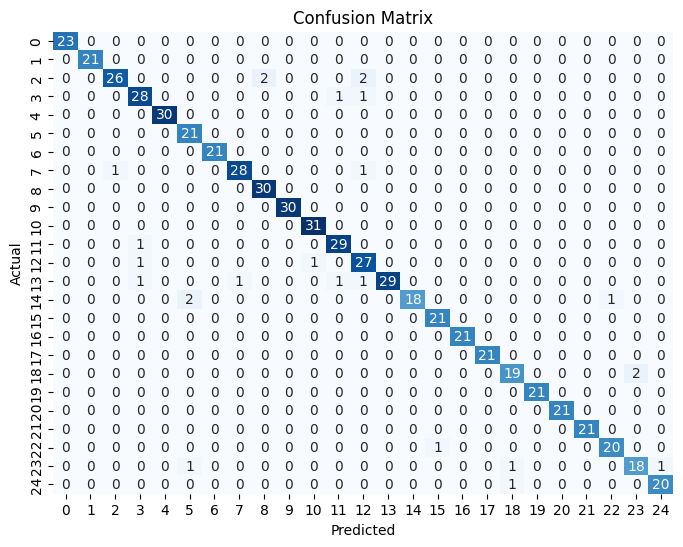

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
with open("/fab3/btech/2021/manish.kumar21b/manish/PlantPedia/endsem/class_labels.txt", "w") as file:
    for class_name in train_dataset.classes:
        file.write(class_name + "\n")

In [ ]:
model_path = "/fab3/btech/2021/manish.kumar21b/manish/PlantPedia/endsem/model/trained_model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Model saved to {model_path}")

Model saved to /fab3/btech/2021/manish.kumar21b/manish/PlantPedia/endsem/model/trained_model.pkl
